In [10]:
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import time

In [11]:
_time = time.time()
lines = []
with open("mydata/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("lines",len(lines))#passed
print("_time ",(time.time() - _time))

lines 6787
_time  0.07805299758911133


In [12]:
_time = time.time()
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("_time ",(time.time() - _time))

_time  1.361241102218628


In [15]:
from sklearn.utils import shuffle
_time = time.time()
"""
images = []
measures = []
filename = ''
current_path = ''
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = "data/IMG/"+filename
        image = cv2.imread(current_path)
        #image = cv2.imread(source_path)
        images.append(image)
        images.append(cv2.flip(image,1))
        measure = float(line[i+3])
        measures.append(measure)
        measures.append(measure*-1.0)
"""  
BATCH_SIZE =16

def generator(samples, batch_size=32):
    correction = 0.2
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    if(i == 0):
                        source_path = line[i]
                        source_path = source_path.replace(" ", "")
                        filename = source_path.split('\\')[-1]
                        current_path = "mydata/IMG/"+filename
                        image = cv2.imread(current_path)
                        image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        """    
                        if(i == 1):#left vam
                            measure = float(line[3]) + correction
                        elif(i == 2):#right cam
                            measure = float(line[3]) - correction
                        """
                        measure = float(line[i+3])
                        angles.append(measure)
                        #flip data
                        images.append(cv2.flip(image,1))
                        angles.append(measure*-1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            train_shuffled = sklearn.utils.shuffle(X_train, y_train)
            yield(train_shuffled[0] , train_shuffled[1])
            #yield (X_train, y_train)

train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

#print("measures",len(measures))#passed
#print("measures ex:",measures[len(measures)-1])#passed
#print("images",len(images))#passed

print("_time ",(time.time() - _time))

_time  0.0


<generator object generator at 0x000002F64A2E9DB0>
<class 'tuple'>
32
label: 0.0


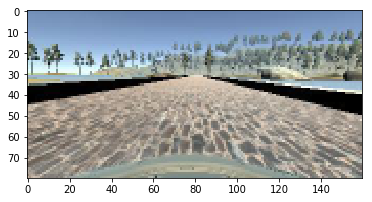

In [16]:
#making sure generator is fine

print(train_generator)
el_next = next(train_generator)
print(type(el_next))
print(len(el_next[0]))
print("label:",el_next[1][0])
#"""
#print(train_samples[0])
test_image = np.array(el_next[0][0])


#cv_rgb = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()
#"""

In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Conv2D, Cropping2D, Dropout

Using TensorFlow backend.


In [18]:
_time = time.time()
#ch, row, col = 3, 80, 320  # Trimmed image format
ch, row, col = 3, 160*.5, 320*.5  # Trimmed image format
#model :
model = Sequential()
#normalize and mean center
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(row,col,ch)))# output(None, 80, 160, 3)
model.add(Cropping2D(cropping=((35,12), (1,1)), input_shape=(row,col,ch)))# output (None, 33, 160, 3) 
#NVidia
model.add(Conv2D(16,(3, 3), input_shape=(33, 158, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))


model.summary()

print("_time ",(time.time() - _time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 80, 160, 3)        0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 33, 158, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 156, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 78, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 76, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 38, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 36, 64)         18496     
__________

In [19]:
from keras.optimizers import Adam

_time = time.time()

#train
model.compile(loss='mse', optimizer=Adam(lr=0.1), metrics=['accuracy'])
#hist = model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=10, verbose=1)
#hist = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=10)
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/BATCH_SIZE, validation_data=validation_generator, validation_steps=len(validation_samples)/BATCH_SIZE, epochs=5)
#hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/batch_size)

#hist = model.fit_generator(train_generator,steps_per_epoch=200, validation_steps=30, epochs=3,validation_data=validation_generator)
print("_time ",(time.time() - _time))


Epoch 1/5
340/339 [==============================] - 76s - loss: 3581465.0463 - acc: 0.9653 - val_loss: 0.1878 - val_acc: 1.0000

{'acc': [0.7249701870120059, 0.7471094525867236, 0.8296520984048587, 0.9998963030116297, 0.9323378448483362], 'loss': [6668076.534282183, 0.28268240741501144, 0.21219697000125942, 0.12450528765312527, 0.17406472221403957], 'val_acc': [1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.1890492589764334, 0.1792805793125238, 0.16762548707314393, 0.15697501599788666, 0.14250372350215912]}


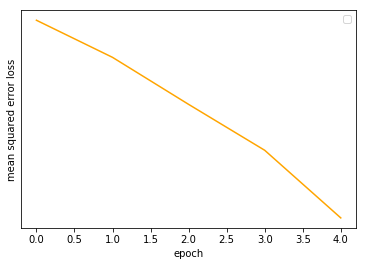

In [7]:
#history = {'val_acc': [1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [6668076.5342821833, 0.28268240741501144, 0.21219697000125942, 0.12450528765312527, 0.17406472221403957], 'acc': [0.72497018701200588, 0.74710945258672357, 0.82965209840485865, 0.99989630301162968, 0.93233784484833615], 'val_loss': [0.1890492589764334, 0.17928057931252381, 0.16762548707314393, 0.15697501599788666, 0.14250372350215912]}

print(hist.history)
#plt.plot(history['loss'])
#plt.plot(history['val_loss'])
#plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.semilogy(history['loss'])
plt.semilogy(history['val_loss'],color='orange')
plt.show()

In [ ]:
#save
model.save('model_nvidia_1.h5')

In [ ]:
#checkpoint--------------------------------------
#load
from keras.models import load_model
continue_model = load_model('model.h5')

In [ ]:
continue_model.compile(loss='mse', optimizer='adam')
continue_model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=4, verbose=1)

In [32]:
del model